In [59]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import sys
import pathlib
import pickle
import numpy as np
import re
import pandas as pd
import math

In [61]:
import pals
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp, get_ms1_peaks
from pals.feature_extraction import DataSource
from pals.PALS import PALS
from pals.ORA import ORA
from pals.common import *
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt


In [57]:
import django
from met_explore.models import *
from met_explore.compound_selection import CompoundSelector

In [58]:
cmpd_select = CompoundSelector()
cmpd_select.update_std_cmpds()

Checking for Standard compounds without DB identifiers


## Get Fly intensity DF from DB

Assume token is stored in environmental variable *PIMP_API_TOKEN*

In [62]:
token = get_pimp_API_token_from_env()

In [7]:
"""
Get an peak_id v sample_id DF containing all the peak intesity values. For use in the pathway analysis.
"""
def get_pals_int_df():
    # Sample peaks are all the sample peaks that we want to look at - in the case of FlyMet this is all the peaks
    psi = SamplePeak.objects.values_list('peak', 'sample', 'intensity')
    peaks, samples, intensities = zip(*psi)
    dpeaks = sorted(list(set(peaks)))
    dsamples = sorted(list(set(samples)))
    peakdict = dict(zip(dpeaks, range(len(dpeaks))))
    sampledict = dict(zip(dsamples, range(len(dsamples))))
    
    rows = [peakdict[_] for _ in peaks]
    cols = [sampledict[_] for _ in samples]
    data = coo_matrix((intensities, (rows, cols)),  dtype=np.float32)
    sample_names = Sample.objects.filter(id__in=dsamples).order_by('id').values_list('name', flat=True)
    
    int_df = pd.DataFrame(data.todense(), index=dpeaks, columns=sample_names)
    int_df.replace(0, np.nan, inplace=True)
    int_df.index.name = "row_id"
#     int_df.columns.name = "sample_name"
    
    return int_df
    
    

In [8]:
fly_int_df = get_pals_int_df()

In [9]:
display (fly_int_df.head())

,sak_a_1.mzXML,sak_a_2.mzXML,sak_a_3.mzXML,sak_a_4.mzXML,sak_b_1.mzXML,sak_b_2.mzXML,sak_b_3.mzXML,sak_b_4.mzXML,sak_c_1.mzXML,sak_c_2.mzXML,...,WHL_F7.mzXML,WHL_F8.mzXML,WHL_M5.mzXML,WHL_M6.mzXML,WHL_M7.mzXML,WHL_M8.mzXML,WHL_L5.mzXML,WHL_L6.mzXML,WHL_L7.mzXML,WHL_L8.mzXML
row_id,,,,,,,,,,,,,,,,,,,,,
1,1.562669e+09,1.517098e+09,1.315216e+09,9.578396e+08,1.271787e+09,9.971529e+08,9.000910e+08,1.246483e+09,1.158794e+09,1.043938e+09,...,6.744516e+08,6.957784e+08,7.762029e+08,6.793557e+08,6.220065e+08,6.003108e+08,9.027932e+08,7.498698e+08,7.958429e+08,7.886959e+08
2,2.396000e+05,1.536655e+05,1.507570e+05,2.429333e+05,1.272114e+05,1.841798e+05,1.692369e+05,1.467720e+05,3.553176e+05,2.878979e+05,...,4.703985e+05,2.910702e+05,6.517739e+05,3.841179e+05,8.949991e+05,4.623417e+05,5.004987e+05,2.208489e+05,6.287192e+05,5.585469e+05
3,1.582114e+05,1.301176e+05,1.281426e+05,1.787866e+05,5.316518e+04,4.199583e+04,6.084546e+04,4.908939e+04,5.642276e+05,8.650861e+05,...,1.080154e+05,1.779219e+05,2.197984e+05,4.578266e+05,2.215362e+05,9.766218e+04,1.092804e+05,9.849900e+04,1.114252e+05,5.771446e+04
4,2.430195e+07,2.062104e+07,1.748787e+07,1.230220e+07,1.682562e+07,1.171661e+07,1.109423e+07,1.893722e+07,1.597692e+07,1.314430e+07,...,1.090871e+07,1.286648e+07,1.326417e+07,1.164670e+07,1.106195e+07,8.818674e+06,1.614863e+07,1.381885e+07,1.394710e+07,1.433545e+07
5,7.001850e+06,5.618816e+06,4.293162e+06,2.466064e+06,4.251425e+06,3.093546e+06,2.519724e+06,4.662197e+06,4.066580e+06,3.457904e+06,...,2.953737e+06,3.124210e+06,4.187230e+06,2.948180e+06,2.457693e+06,2.384858e+06,5.150226e+06,3.390230e+06,3.494155e+06,3.811794e+06


### Heatmap for PALS paper

In [38]:
whole_f =[col for col in fly_int_df if col.startswith('sak_a')]

In [39]:
mid_f = [col for col in fly_int_df if col.startswith('sak_g')]

In [44]:
peak_secId_list = [4812,4456,4654,5469,4850,6044,7409,6079,6400]

In [46]:
peak_id_list = []
for p in peak_secId_list:
    p_id = Peak.objects.get(psec_id=p).id
    peak_id_list.append(p_id)
    

In [47]:
print (peak_id_list)

[271, 601, 114, 116, 2982, 3080, 3081, 1006, 1007]


In [48]:
pw_peaks = fly_int_df.loc[peak_id_list]

In [49]:
for_heatmap = pw_peaks[whole_f + mid_f]
display(for_heatmap)

,sak_a_1.mzXML,sak_a_2.mzXML,sak_a_3.mzXML,sak_a_4.mzXML,sak_g_1.mzXML,sak_g_2.mzXML,sak_g_3.mzXML,sak_g_4.mzXML
row_id,,,,,,,,
271,3.559058e+06,3.193915e+06,3.102612e+06,2.811210e+06,50267.613281,81009.765625,92278.164062,59894.292969
601,4.494681e+06,3.974893e+06,3.696120e+06,2.309011e+06,38532.343750,79956.945312,33962.218750,16474.589844
114,8.065878e+06,5.370086e+06,4.825879e+06,3.592959e+06,474650.718750,639759.625000,430893.781250,241129.921875
116,9.082786e+05,5.952191e+05,5.591742e+05,4.442367e+05,75616.132812,115806.484375,95640.640625,75169.375000
2982,8.270391e+06,4.990621e+06,7.091120e+06,5.487312e+06,10954.220703,14693.540039,21154.041016,17740.423828
3080,1.100003e+06,5.668128e+05,8.528599e+05,7.198246e+05,23119.025391,26069.767578,24082.951172,25334.923828
3081,7.740897e+04,4.705831e+04,5.813745e+04,6.144274e+04,23254.576172,25455.093750,28331.082031,26099.396484
1006,2.326633e+05,1.449862e+05,1.264184e+05,8.169727e+04,4949.654297,8808.054688,7785.503418,5293.299316
1007,1.144115e+05,1.037760e+05,1.009041e+05,8.828788e+04,5005.470703,5464.533691,4150.408203,8941.018555


In [50]:
df = np.log2(for_heatmap)
display(df)

,sak_a_1.mzXML,sak_a_2.mzXML,sak_a_3.mzXML,sak_a_4.mzXML,sak_g_1.mzXML,sak_g_2.mzXML,sak_g_3.mzXML,sak_g_4.mzXML
row_id,,,,,,,,
271,21.763063,21.606894,21.565052,21.422760,15.617342,16.305809,16.493702,15.870131
601,22.099787,21.922485,21.817581,21.138844,15.233783,16.286936,15.051643,14.007955
114,22.943399,22.356514,22.202360,21.776741,18.856506,19.287170,18.716972,17.879452
116,19.792776,19.183062,19.092937,18.760969,16.206406,16.821356,16.545336,16.197857
2982,22.979525,22.250788,22.757582,22.387669,13.419199,13.842895,14.368646,14.114753
3080,20.069077,19.112513,19.701950,19.457287,14.496793,14.670090,14.555724,14.628839
3081,16.240213,15.522161,15.827180,15.906955,14.505227,14.635667,14.790098,14.671729
1006,17.827885,17.145555,16.947847,16.318001,12.273112,13.104608,12.926575,12.369951
1007,16.803873,16.663115,16.622625,16.429928,12.289290,12.415883,12.019037,13.126224


In [51]:
df.columns =['A1', 'A2','A3','A4','B1', 'B2','B3','B4']
df.index.name='Peak ids'
df.columns.name='Samples'


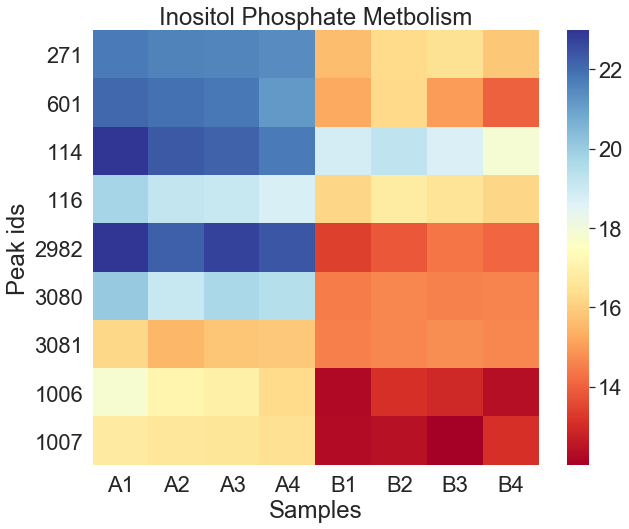

In [52]:
%matplotlib inline
import numpy as np
import seaborn as sns
plt.figure(figsize=(10,8))
ax = plt.axes()
sns.set(font_scale=2)
ax.set_title('Inositol Phosphate Metbolism')
svm = sns.heatmap(df, cmap="RdYlBu")
fig = svm.get_figure()
fig.savefig('inositol.png', dpi=600)

### Get annotation DF - all the peaks with all of the compound identifications as a dataframe.

###Update standard compounds to get 

In [53]:
cmpds = Compound.objects.all()
cmpd_select = CompoundSelector()

In [ ]:
#This method is to check the compound database and check for standard 
# compounds that don't have any other DB identifiers that would make them useful for other methods.
def update_std_cmpds():

missing_cmpd_dict = cmpd_select.missing_cmpd_dict
for c in cmpds:
    all_ids = c.get_all_identifiers()
    if len(all_ids)==1 and 'stds_db' in all_ids:
        print (all_ids)
        print (c.id)
        print  (c.cmpd_name)
        
        # If the name is found under a different compound ID add the std_
        name_match = CompoundDBDetails.objects.filter(~Q(compound_id=c.id), cmpd_name=c.cmpd_name)
        if name_match:
            
            print ("Name match")
            matching_cmpd_id = name_match[0].compound_id #Take the first/only matching compound.
            matching_cmpd = Compound.objects.get(id=matching_cmpd_id)
            #c is the standard compound under the above if statement

            std_cmpd_db = CompoundDBDetails.objects.get(compound_id=c.id)

            std_db_name = std_cmpd_db.db_name
            std_cmpd_id = std_cmpd_db.identifier


            new_cmpd_details, created_cmpd_details =  CompoundDBDetails.objects.get_or_create(db_name=std_db_name, 
                                                    identifier=std_cmpd_id, cmpd_name=c.cmpd_name, compound=matching_cmpd)
            
            
            ##If the confidence of the annotation for this peak is 4, update the annotation      
            
            std_annot = Annotation.objects.filter(compound=c)       
            new_cmpd_annot =  Annotation.objects.filter(compound=matching_cmpd)
              
            #Update the annotation to true for the standard cmpd - with checks.
            for s in std_annot:
                for n in new_cmpd_annot:
                    if s.peak==n.peak and s.identified and s.confidence==4: 
                        
                        #Same peaks/same compound should be same annotation
                        print ("Updating identity and confidence scores to the standard cmpd")
                        n.identified=True 
                        n.confidence=4
                        n.save()
            
            #Delete the original cmpd.
            print ("deleting", c)
            c.delete() #delete the std_cmpd with no DB identifiers.
        else: # no name match
#         #Currenly we only have kegg IDs in the dictonary - this will need refactored if this changes.
            print ("No name match")
            db_name  = DBNames.objects.get(id=2)
            added_id = missing_cmpd_dict[c.cmpd_name] 
            new_cmpd_details, created_cmpd_details =  CompoundDBDetails.objects.get_or_create(db_name=db_name, identifier=added_id,
                                                                cmpd_name=c.cmpd_name, compound=c)
        
        
        if created_cmpd_details:
            print("New cmpd details were created", new_cmpd_details)
            new_cmpd_details.save()
        
    

In [ ]:
added_id='KEGINS'
try:
    assert(added_id.startswith('C0'))

except AssertionError as error:

    logger.error("This is not a KEGG ID and does not match the dictionary. Please refactor.", error)
    raise
    

In [ ]:
for c in cmpds:
    all_ids = c.get_all_identifiers()
    print (all_ids)
    if (len(all_ids)==1 & all_ids[0].startswith('Std')):
        print (all_ids)

In [ ]:
cmpd.get_all_identifiers()

In [ ]:
peaks, compounds = zip(*annotation_data)

In [ ]:
peak_ids =(list(peaks))
cmpd_ids = list(compounds)

In [ ]:
chebi = 'chebi_id'

In [ ]:
db_names = DBNames.objects.all()
columns = [d.db_name for d in db_names if d.db_name !='stds_db']

In [ ]:
columns.insert(0, chebi)

In [ ]:
annotation_df = pd.DataFrame(columns=columns)
annotation_df.insert(0, 'cmpd_ids', cmpd_ids)
annotation_df.insert(0, 'peak_ids', peak_ids)



In [ ]:
annotation_df.head()

In [ ]:
from itertools import islice
def get_annot_cmpd_df():
    
    annotation_data = Annotation.objects.values_list('peak', 'compound')
    peaks, compounds = zip(*annotation_data)
    
    chebi_col = 'chebi_id'
    db_names = DBNames.objects.all()
    columns = [d.db_name for d in db_names if d.db_name !='stds_db']
    
    columns.insert(0, chebi_col)
    columns.append('entity_id') #This will be the single, chosen identifier for the compound
    
    annotation_df = pd.DataFrame(columns=columns)
    annotation_df.insert(0, 'cmpd_ids', cmpd_ids)
    annotation_df.insert(0, 'peak_ids', peak_ids)
    
    for ix, row in annotation_df.iterrows():
    # for ix, row in islice(annotation_df.iterrows(), 200):
        cmpd = Compound.objects.get(id = row.cmpd_ids)
        chebi_id = cmpd.chebi_id
        annotation_df.loc[ix,'chebi_id']=chebi_id
    
        db_set = cmpd.compounddbdetails_set.all()
        for db in db_set:
            db_name = db.db_name.db_name
            if db_name !='stds_db':
                #Get the DB reference and add it to the dataframe
                db_id = db.identifier 
                annotation_df.loc[ix, db_name]=db_id
    
    return annotation_df
  
  
    

In [ ]:
annot_cmpd_df = get_annot_cmpd_df()

In [ ]:
annot_cmpd_df.head(15)

In [ ]:
no_identifiers = []
for ix, row in annot_cmpd_df.iterrows():
    if row.chebi_id is not None:
         annot_cmpd_df.loc[ix, 'entity_id']=row.chebi_id
    elif (pd.notnull(row.kegg)):
        annot_cmpd_df.loc[ix, 'entity_id']=row.kegg
    elif (pd.notnull(row.hmdb)):
        annot_cmpd_df.loc[ix, 'entity_id']=row.hmdb
    elif (pd.notnull(row.lipidmaps)):
        annot_cmpd_df.loc[ix, 'entity_id']=row.lipidmaps
    else:      
        print ("What the row id", row)
        no_identifiers.append(row.cmpd_ids)

        

    


In [ ]:
"""
For some reason these compounds don't have a standard idenfier 
associated with them (think it's the way they came back from pimp)
I am going to manually add them to the DB to keep things consistent.
"""
#Cmpd 1358 is O-Acetylcarnitine and this has a kegg ID so I'll add it.

#Method is the only cmpd_id the std_db_id??




In [ ]:
print (no_identifiers)

In [ ]:
annot_cmpd_df.head(100)

In [ ]:
annotation_df = annotation_df.set_index('peak_ids')


In [ ]:
cmpd_db_details = CompoundDBDetails.objects.filter(compound=1)

In [ ]:
for c in cmpd_db_details:
    print (c.identifier)

In [ ]:
int_df = get_ms1_intensities(token, hostname, analysis_id)
annotation_df = get_annotation_df(token, hostname, analysis_id, 'kegg')
experimental_design = get_experimental_design(token, hostname, analysis_id)

In [ ]:
int_df, annotation_df, experimental_design = download_from_pimp(token, PIMP_HOST, 1301, 'kegg')

In [ ]:
int_df.head()

In [ ]:
## was 9294 rows × 1 columns

In [ ]:
print (experimental_design)

### PALS analysis using KEGG database exported from PiMP

In [ ]:
ds = DataSource(int_df, annotation_df, experimental_design, DATABASE_PIMP_KEGG)

In [ ]:
pals = PALS(ds, plage_weight=5, hg_weight=1)
pathway_df = pals.get_pathway_df()

### PALS analysis using KEGG database exported from Reactome

In [ ]:
ds = DataSource(int_df, annotation_df, experimental_design, DATABASE_REACTOME_KEGG, 
                reactome_species=REACTOME_SPECIES_HOMO_SAPIENS, reactome_metabolic_pathway_only=True)

In [ ]:
pals = PALS(ds, plage_weight=5, hg_weight=1)
pathway_df = pals.get_pathway_df()

In [ ]:
pathway_df.sort_values('PiMP_KEGG Head_f/Whole_f comb_p')

In [ ]:
head_only_df = pathway_df.sort_values('PiMP_KEGG Head_f/Whole_f comb_p')

In [ ]:
head_only_df

In [ ]:
pathway_df[['pw_name', 'Head_f/Whole_f p-value', 'PiMP_KEGG Brain_m/Whole_m p-value',
            'unq_pw_F','tot_ds_F','F_coverage','sf']].sort_values('Head_f/Whole_f p-value')

In [ ]:
pathway_df[['pw_name', 'Ovary_f/Whole_f p-value', 'PiMP_KEGG Ovary_f/Whole_f comb_p',
            'unq_pw_F','tot_ds_F','F_coverage','sf']].sort_values('Ovary_f/Whole_f p-value').head(60)

In [ ]:
pathway_df.sort_values('Brain_m/Whole_m p-value').iloc(['pw_name', 'Brain_m/Whole_m p-value']

In [ ]:
pathway_df.sort_values('COMPOUND beer1/beer2 comb_p', ascending=True, inplace=True)
pathway_df

### PALS analysis of compounds by connecting to Reactome

In [ ]:
ds = DataSource(int_df, annotation_df, experimental_design, DATABASE_REACTOME_KEGG, 
                reactome_species=REACTOME_SPECIES_HOMO_SAPIENS, reactome_metabolic_pathway_only=True, reactome_query=True)

In [ ]:
pals = PALS(ds, plage_weight=5, hg_weight=1)
pathway_df = pals.get_pathway_df()

In [ ]:
pathway_df.sort_values('COMPOUND beer1/beer2 comb_p', ascending=True, inplace=True)
pathway_df

### ORA Analysis

In [ ]:
ds = DataSource(int_df, annotation_df, experimental_design, DATABASE_PIMP_KEGG)

In [ ]:
ora = ORA(ds)
pathway_df = ora.get_pathway_df()

In [ ]:
pathway_df.sort_values('PiMP_KEGG beer1/beer2 comb_p', ascending=True, inplace=True)
pathway_df